# Soma-axon analysis
*Frederik Rogge, 2022*

Here, we analyze the soma-axon correlations between different soma-axon pairs.

In [99]:
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

In [100]:
# Define base path
base_path = ''

# Load soma data
F = np.load(os.path.join(base_path, 'F.npy'), allow_pickle=True)
Fneu = np.load(os.path.join(base_path, 'Fneu.npy'), allow_pickle=True)
iscell = np.load(os.path.join(base_path, 'iscell.npy'), allow_pickle=True)

# Load axon data
F_axons = np.load(os.path.join(base_path, 'F_axons2.npy'), allow_pickle=True)
Fneu_axons = np.load(os.path.join(base_path, 'Fneu_axons2.npy'), allow_pickle=True)

In [101]:
# Define mapping between somas and axons
soma_axon_mapping = {
    7: [711, 2124],
    42: [842, 930, 1651, 1186, 1345]
}

# Helper function
def calculate_dff(F, Fneu):
    Fc = F - 0.7 * Fneu + np.median(Fneu)
    F0 = np.median(Fc, keepdims=True)
    dFF = (Fc - F0) / F0
    return dFF

### Correlation between example soma-axon pair

In [102]:
pre_size = 10   # Frames before threshold exceed
post_size = 60  # Frames after threshold exceed
min_length = 2  # Minimum length of an event
factor = 2      # Factor x std determines the threshold

# Example ids
roi_id = 7
axon_id = 711

# Determine dFF for soma and axon
dFF = calculate_dff(F[roi_id], Fneu[roi_id])
dFF_axon = calculate_dff(F_axons[axon_id], Fneu_axons[axon_id])

# Determine where the threshold of 2std is exceeded
std = np.std(dFF)
thresh = factor * std
mask = np.where(dFF > thresh, True, False)
thresh_exceeds = np.argwhere(mask[1:] > mask[:-1]).squeeze() + 1
thresh_less = np.argwhere(mask[1:] < mask[:-1]).squeeze()

# Collect non-overlapping windows around these threshold exceeds
windows = []
count = 0
for ex, down in zip(thresh_exceeds, thresh_less):
    if count == 0 or (windows[count-1][1] < ex-pre_size and ex + min_length <= down):
        windows.append([ex-pre_size, ex+post_size])
        count += 1

### Plot signals and windows

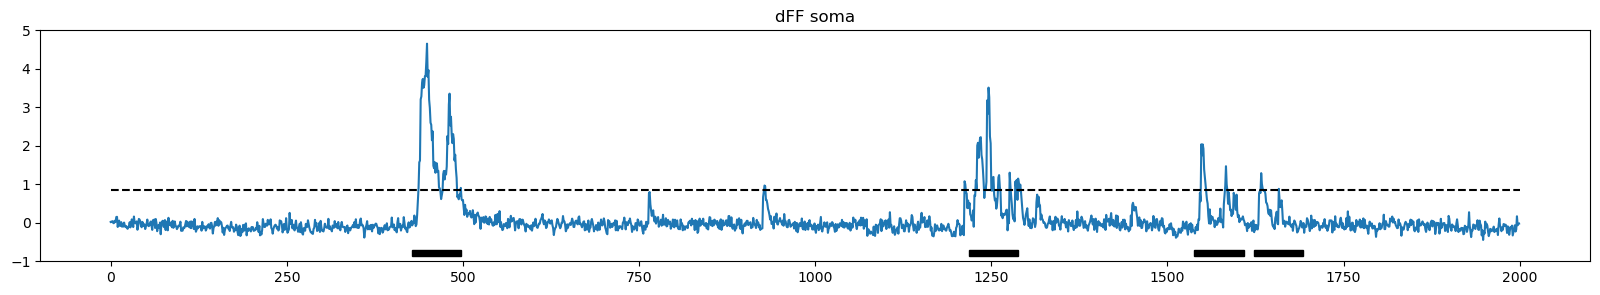

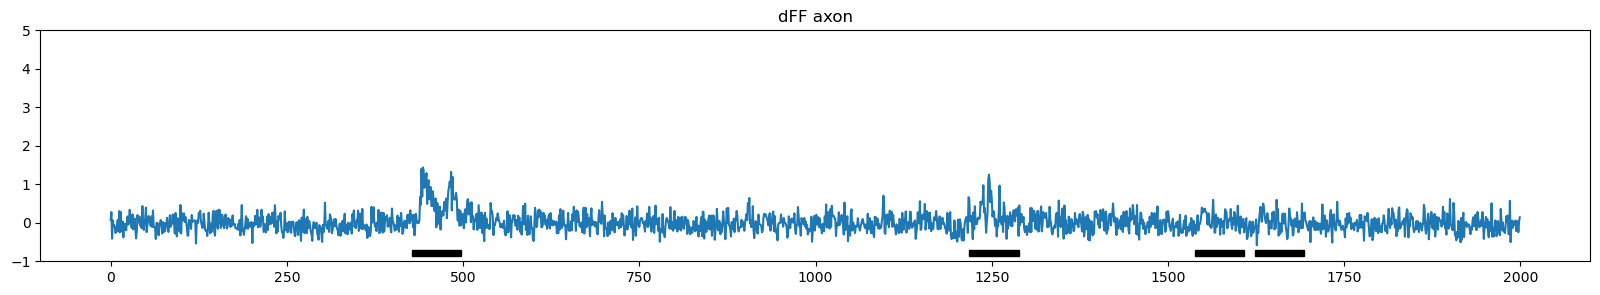

Found 67 windows


In [104]:
min_size = 0
max_size = 2000

# Plot soma activity
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dFF[min_size:max_size])
ax.set_ylim([-1, 5])
ax.hlines(xmin=0, xmax=max_size-min_size, y=thresh, linestyles='dashed', color='black')
for w in windows:
    if w[1] < max_size and min_size < w[0]:
        ax.axvspan(w[0]-min_size, w[1]-min_size, ymin=0.025, ymax=0.05, alpha=1, color='black')
ax.set_title('dFF soma')
plt.show()

# Plot axon activity
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(dFF_axon[min_size:max_size])
ax.set_ylim([-1, 5])
for w in windows:
    if w[1] < max_size and min_size < w[0]:
        ax.axvspan(w[0]-min_size, w[1]-min_size, ymin=0.025, ymax=0.05, alpha=1, color='black')
ax.set_title('dFF axon')
plt.show()

print(f'Found {len(windows)} windows')

### Collect correlations for all soma-axon pairs

In [106]:
correlations_dict, windows_dict = {}, {}
for soma, axons in soma_axon_mapping.items():

    # Init dict to save correlations
    correlations_dict[soma] = {}

    # Get dFF for this soma
    dFF = calculate_dff(F[soma], Fneu[soma])

    # Determine threshold
    thresh = factor * np.std(dFF)

    # Determine where the threshold of 2std is exceeded and where the signals goes below threshold again
    mask = np.where(dFF > thresh, True, False)
    thresh_exceeds = np.argwhere(mask[1:] > mask[:-1]).squeeze() + 1
    thresh_less = np.argwhere(mask[1:] < mask[:-1]).squeeze()

    # Collect non-overlapping windows around these threshold exceeds
    windows = []
    count = 0
    for ex, down in zip(thresh_exceeds, thresh_less):
        if count == 0 or (windows[count-1][1] < ex-pre_size and ex + min_length <= down):
            windows.append([ex-pre_size, ex+post_size])
            count += 1

    # Now, iterate over corresponding axons
    for axon in axons:

        # Init list to save correlations
        correlations_dict[soma][axon] = []

        # Determine dFF for axon
        dFF_axon = calculate_dff(F_axons[axon], Fneu_axons[axon])

        # Iterate over pre-determined windows
        for window in windows:

            # Calculate pearson correlation between axon and soma_axon_mapping
            pc, _ = scipy.stats.pearsonr(dFF[window[0]: window[1]], dFF_axon[window[0]: window[1]])

            # Append to list
            correlations_dict[soma][axon].append(pc)


### Plot correlations for all pairs

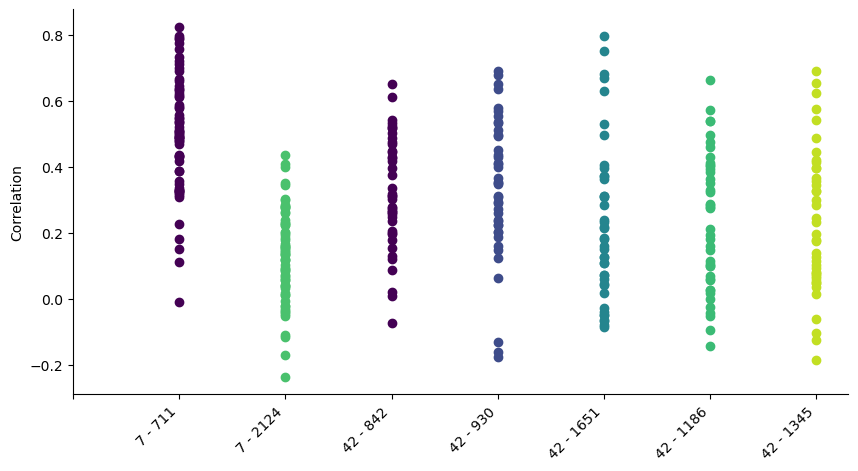

In [107]:
# Get normalized colormap
fig, ax = plt.subplots(figsize=(10, 5))

correlations_dict_flat = {}
c = 1
labels = []
for i, (soma, ax_corrs) in enumerate(correlations_dict.items()):

    cm = plt.get_cmap("viridis")
    colors = [
        cm(x / (len(ax_corrs.keys()) - 0.6)) for x in list(range(len(ax_corrs.keys())))
    ]

    for n, (axon, ax_corr) in enumerate(ax_corrs.items()):
        labels.append(f'{soma} - {axon}')
        ax.scatter(np.ones(len(ax_corr)) * c, ax_corr, color=colors[n])
        c += 1
        correlations_dict_flat[f'{soma} - {axon}'] = ax_corr

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([i for i in range(c)])
ax.set_xticklabels([''] + labels, rotation=45, ha='right')
ax.set_ylabel('Correlation')
plt.show()


Export as dataframe

In [108]:
df = pd.DataFrame.from_dict(correlations_dict_flat, orient='index').T
print(df)

     7 - 711  7 - 2124  42 - 842  42 - 930  42 - 1651  42 - 1186  42 - 1345
0   0.791128  0.436130  0.235647  0.203653  -0.038092   0.026251  -0.185450
1   0.634936  0.285334  0.542842  0.533233   0.218311   0.431434   0.328316
2   0.557155  0.194288  0.650263  0.691071   0.405798   0.459280   0.421309
3   0.357125  0.136309  0.524975  0.652006   0.310419   0.323760   0.398291
4   0.644179  0.032123  0.278360  0.635637   0.629249   0.410869   0.689933
..       ...       ...       ...       ...        ...        ...        ...
62  0.480257 -0.109681       NaN       NaN        NaN        NaN        NaN
63  0.431339  0.400676       NaN       NaN        NaN        NaN        NaN
64  0.539053  0.280032       NaN       NaN        NaN        NaN        NaN
65  0.326203  0.039195       NaN       NaN        NaN        NaN        NaN
66  0.491112  0.156580       NaN       NaN        NaN        NaN        NaN

[67 rows x 7 columns]
